# Notebook for Freeze/Frost Products for Alabama

In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import datetime as dt

import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

In [ ]:
# User inputs

# Select Freeze Frost Threshold
# 16,20,24,28,32,36
F_THRES = 16
# First or Last Freeze
F_LAST = True

#
PROJ = ccrs.epsg(32616)

## Read in Freeze/Frost CSV

---

Filter out no data stations, any station not in Alabama, and by user selected threshold


In [ ]:
# Read in .csv file
df = pd.read_csv(Path('../data/frost_freeze_stn_data_al.csv'))

# Drop any rows with no data
df_sub = df.dropna(how='any').copy()

# Filter out non-AL stations
df_sub = df_sub[df_sub.NAME.str.contains("AL US")].copy()

AL_CT = gpd.read_file(Path('../ACR/UScounties/'))
AL_CT = AL_CT[AL_CT.STATE_NAME == 'Alabama']

str_flag = 'PRBLST' if F_LAST else 'PRBFST'

DF_THRES = df_sub[
    df_sub.columns[:4].tolist() + 
    df_sub.columns[df_sub.columns.str.contains(str(F_THRES)) & df_sub.columns.str.contains(str(str_flag))].tolist()
                  ]

In [ ]:
freeze_cols = [c for c in DF_THRES.columns if c.startswith(f"ANN-TMIN-PRBLST-T")]


In [ ]:
DF_THRES.loc[:,freeze_cols] = DF_THRES[freeze_cols].apply(lambda x: ((pd.to_datetime(x.str.strip(),format="%m/%d", errors="coerce").dt.dayofyear - 182) % 365))

In [ ]:
DF_THRES[freeze_cols] = DF_THRES[freeze_cols].apply(pd.to_numeric, errors='coerce')

/tmp/ipykernel_26400/2419938381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_THRES[freeze_cols] = DF_THRES[freeze_cols].apply(pd.to_numeric, errors='coerce')


## Geolocate all stations and plot on map

In [ ]:
GEO = [Point(lon,lat) for lon,lat in zip(DF_THRES.LONGITUDE,DF_THRES.LATITUDE)]
DF_GEO = gpd.GeoDataFrame(DF_THRES, geometry=GEO, crs='EPSG:4326')

In [ ]:
def doy_to_mmdd(doy):
    doy = (doy + 182) % 365
    doy = 365 if doy == 0 else doy
    if np.isnan(doy):
        return doy
    return (dt.datetime(2001,1,1) + dt.timedelta(doy-1)).strftime("%m/%d")

In [ ]:
vmin_f=DF_GEO[freeze_cols].min().min()
vmax_f=DF_GEO[freeze_cols].max().max()

/tmp/ipykernel_26400/107654432.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_yticklabels([doy_to_mmdd(t) for t in ticks])


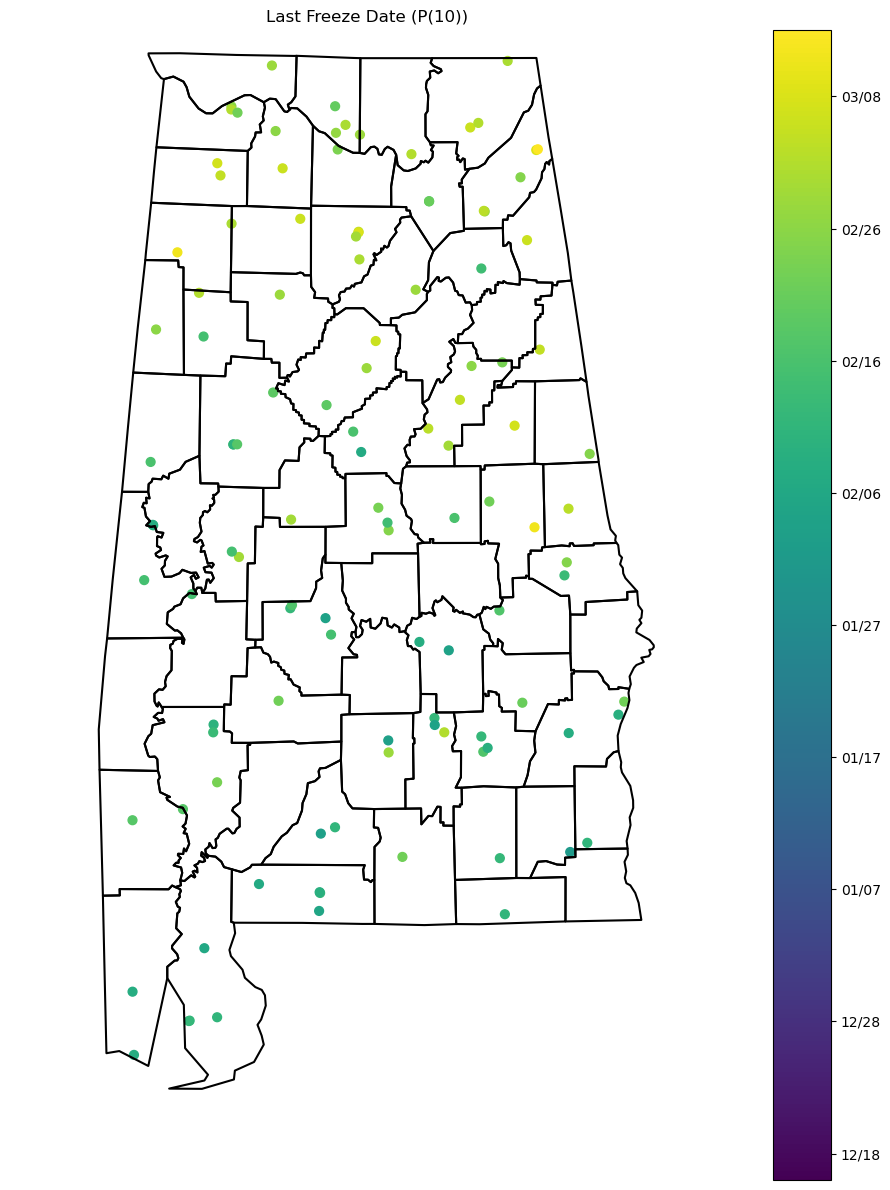

In [ ]:
fig,ax = plt.subplots(figsize=(10,12),subplot_kw={'projection':PROJ})

ax.set_extent([-89,-84.5,29.8,35.1],crs=ccrs.PlateCarree())

col = f'ANN-TMIN-PRBLST-T{F_THRES}FP10'
# df_plot = DF_GEO[~DF_GEO[col].str.contains('-9999')]
df_plot = DF_GEO.copy()
# df_plot = DF_GEO[
#     ~DF_GEO[col].str.contains('-9999') & DF_GEO[f'comp_flag_ANN-TMIN-PRBLST-T{F_THRES}FP10'].str.contains('S')
#     ]
_plot = df_plot.plot(
    column=col,
    ax=ax,
    vmin=vmin_f,
    vmax=vmax_f,
    cmap='viridis',
    markersize=40,
    legend=True,
    transform=ccrs.PlateCarree())

cbar = ax.get_figure().axes[-1]
ticks = cbar.get_yticks()
cbar.set_yticklabels([doy_to_mmdd(t) for t in ticks])

ax.set_title('Last Freeze Date (P(10))')
ax.add_geometries(AL_CT.geometry, crs=ccrs.PlateCarree(), facecolor='none', linewidth=1.5,
                      edgecolor='black')
ax.set_axis_off()
plt.tight_layout()

## Interactive

In [ ]:
def plot_prob(p):
    col = f'ANN-TMIN-PRBLST-T{F_THRES}FP{p}'

    fig,ax = plt.subplots(figsize=(10,12),subplot_kw={'projection':PROJ})

    ax.set_title(f'Last Freeze Date for {F_THRES}°F for P({p})')
    
    ax.set_extent([-89,-84.5,29.8,35.1],crs=ccrs.PlateCarree())

    ax.add_geometries(AL_CT.geometry, crs=ccrs.PlateCarree(), facecolor='none', linewidth=1.5,
                      edgecolor='black')
    ax.set_axis_off()

    df_plot.plot(
        ax=ax,
        column=col,
        cmap='viridis',
        vmin = vmin_f,
        vmax = vmax_f,
        legend=True,
        markersize=40,
        transform=ccrs.PlateCarree()
        )
    
    cbar = ax.get_figure().axes[-1]
    num_ticks = 9
    tick_locs = np.linspace(vmin_f,vmax_f, num_ticks)
    cbar.yaxis.set_major_locator(mticker.FixedLocator(tick_locs))
    cbar.set_yticklabels([doy_to_mmdd(t) for t in tick_locs])


    ticks = cbar.get_yticks()
    cbar.set_yticklabels([doy_to_mmdd(t) for t in ticks])
    
    
    

In [ ]:
widgets.interact(plot_prob,
                 p=widgets.IntSlider(min=10,max=90,step=10,value=50)
                 )

interactive(children=(IntSlider(value=50, description='p', max=90, min=10, step=10), Output()), _dom_classes=(…

<function __main__.plot_prob(p)>